# Port Recognition

Very similar to scalable vertex recognition. Read that manual.

#### Learnings:
* Watch out: no white pixel in a plot does not mean that there is no white data point!!!
* Convert shapes: rsvg-convert output.svg -w 20 -h 20 -o output.png 

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go


### Input and Transparency (Alpha) Management

In [14]:
activate_plotly = False
threshold = 0.3e7 # finds 2 inputs
threshold = 1.0e7 # finds 2 ports
threshold = 0.4 # finds 2 ports
# threshold = 0.5e7 # for gimp = unknown token

# Define the paths
# target_image_path = '3boxes_labels.png'
# target_image_path = '00_3boxes_labels_scaled_unknown.png'
# target_image_path = '00_3boxes_labels_scaled_error_port.png'
# target_image_path = 'door_system.png'
target_image_path = "images/deviceeditor.png" # version 2 for paper with scaled vertex
# target_image_path = 'door_system_after_preprocessing_big.png' # without padding for other screenshots
# template_image_path = 'output.png'
template_image_path = "images/black_square.png"

target_img = cv2.imread(target_image_path)
template_img = cv2.imread(template_image_path)

#### Visualization of Input

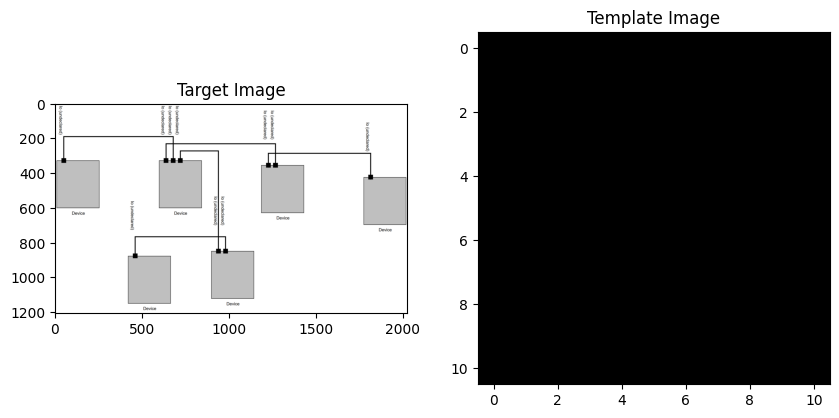

In [15]:
# plot target image and template_img_with_alpha
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')
ax[1].imshow(cv2.cvtColor(template_img, cv2.COLOR_BGRA2RGBA))
ax[1].set_title('Template Image')
plt.show()

### Template Matching

For some reason TM_SQDIFF_NORMED is not normed to 0..1, this could be because of mask of 3 channels.

Template matching works with mask but only for the template [SO](https://stackoverflow.com/a/44693722)
Docu template matching [opencv tut](https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html)
[opencv doc](https://docs.opencv.org/3.0.0/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be)

Great explanation why we should use a least squares the key is that on a white background you would have to problem of dividing by zero. [SO](https://stackoverflow.com/questions/44690002/python-opencv-matchtemplate-on-grayscale-image-with-masking)

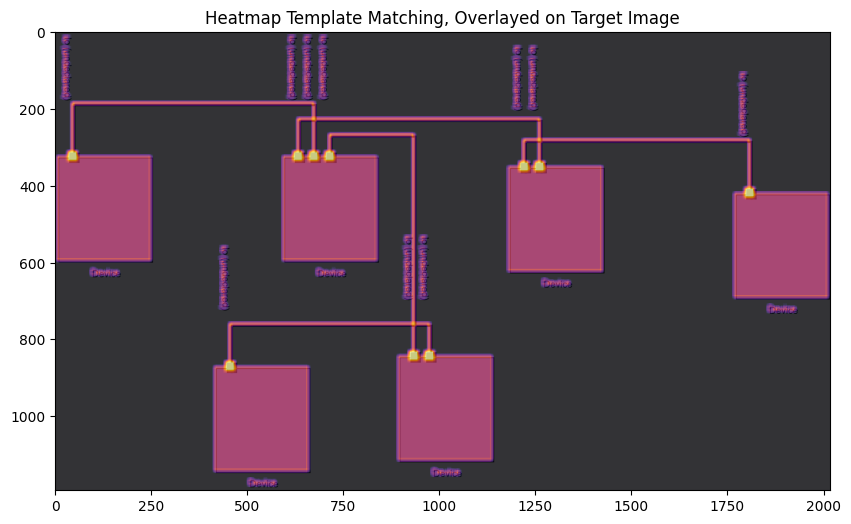

In [16]:
# Apply template matching
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED, mask=template_alpha_mask_3)

# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCORR_NORMED, mask=template_alpha_mask)
# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCOEFF_NORMED)
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF, mask=template_alpha_mask_3 ) # working
res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF) # experiment to normalize

# Overlay non logarithmic heatmap on the original image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.imshow(res, cmap='inferno_r', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
plt.title('Heatmap Template Matching, Overlayed on Target Image')
plt.show()

#### Template Matching Debug Output

In [17]:
# print max of res
print('Max of res: ', np.max(res))
# print min of res
print('Min of res: ', np.min(res))
print('Shape of res: ', res.shape)

# print shape of template and target
print('Shape of template: ', template_img.shape)
print('Shape of target: ', target_img.shape)

# print the data types
print('Data type of template: ', template_img.dtype)
print('Data type of target: ', target_img.dtype)



Max of res:  23604076.0
Min of res:  0.0
Shape of res:  (1193, 2017)
Shape of template:  (11, 11, 3)
Shape of target:  (1203, 2027, 3)
Data type of template:  uint8
Data type of target:  uint8


#### Visualization of Template Matching

In [18]:
# # # Draw a logarithmic heat map of the result, not relevant if normalized Template Matching is used
# # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# # ax.imshow(np.log(res), cmap='inferno_r')
# # plt.title('Logarithmic Heatmap of the Result of Template Matching')
# # plt.show()

# # Draw non logarithmic heat map
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(res, cmap='inferno_r', vmin=0, vmax=1)
# plt.title('Heatmap Template Matching (Normalized)')
# plt.show()

# # Overlay the heatmap on the original image
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
# ax.imshow(np.log(res), cmap='inferno_r', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
# plt.title('Heatmap Template Matching (Logarithmic), Overlayed on Target Image')
# plt.show()

# # Overlay non logarithmic heatmap on the original image
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
# ax.imshow(res, cmap='inferno_r', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
# plt.title('Heatmap Template Matching, Overlayed on Target Image')
# plt.show()

#### Visualization of Template Matching 3D with plotly

In [19]:
# draw with plotly non logarithmic
activate_plotly = False
if activate_plotly:
    fig = go.Figure(
        data=[
            go.Surface(z=res[::-1],
             colorscale='inferno_r')
             ]
             )
    fig.update_layout(title='Heatmap Template Matching (Normalized)', 
                      height=1500, 
                      scene=dict(
                          zaxis=dict(autorange="reversed")
                          )
                     )
    fig.show()

#### Visualization of Template Matching 3D with plotly with screenshot for paper

In [20]:
# template matching data processing
template_matching_result = res.copy()
# z_data = -np.log(template_matching_result[::-1])
z_data = template_matching_result[::-1]
# mirror z_data
z_data = np.flipud(z_data)

# target image data processing
target_img_cropped = target_img[:template_matching_result.shape[0], :template_matching_result.shape[1], :]
target_img_cropped_gray = cv2.cvtColor(target_img_cropped, cv2.COLOR_BGR2GRAY)
# z_image = np.ones_like(target_img_cropped_gray)*-16.8 # 16.7 is good
z_image = np.ones_like(target_img_cropped_gray)*0.8 # 0.8 is good
z_image = np.flipud(z_image)


activate_plotly = False
if activate_plotly:
    fig = go.Figure()

    # Layer 1: 3D Plot of Heatmap
    fig.add_trace(go.Surface(
        z=z_data,
        showscale=False,
        colorscale='inferno_r'
        ))

    # Layer 2: 2D Plot of Target Image at 0.1 (for aesthetics)
    fig.add_trace(go.Surface(
        z=z_image, 
        surfacecolor=target_img_cropped_gray, 
        colorscale='gray', 
        showscale=False
        ))
    
    fig.update_layout(title='Heatmap Template Matching', 
                      scene=dict(
                        yaxis=dict(autorange='reversed'),
                        zaxis=dict(autorange="reversed") 
                      ),
                      height=1500,
                      scene_aspectratio=dict(x=2, y=1, z=0.5),
                      )
    fig.show()

## Thresholding

### Histogram for Thresholding
IDEA use a more generic threshold somehow using the information from the histogram. This is currently a hardcoded threshold which is not perfect.

In [21]:
# # draw a logarithmic histogram of the result
# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# ax.hist(res.flatten(), bins=256, log=True)
# # visualize the threshold
# ax.axvline(x=threshold, color='r', linestyle='--')
# plt.title('Logarithmic Histogram of the Result of Template Matching')
# plt.show()

## Visualization after Thresholding

### Threshold Template Matching

In [22]:

# IDEA: make threshold in %, somehow related to area.
# and analyse with plotly what else is almost detected
loc = np.where(res < threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 2907 matches with a threshold of 0.4


### Analysis After Thresholding

In [23]:
# Set all values over the threshold to 1 (was 2e7) (which kind of resembles "zero")
thresholded_res = np.copy(res)
thresholded_res[thresholded_res > threshold] = 1

### 2D Visualization

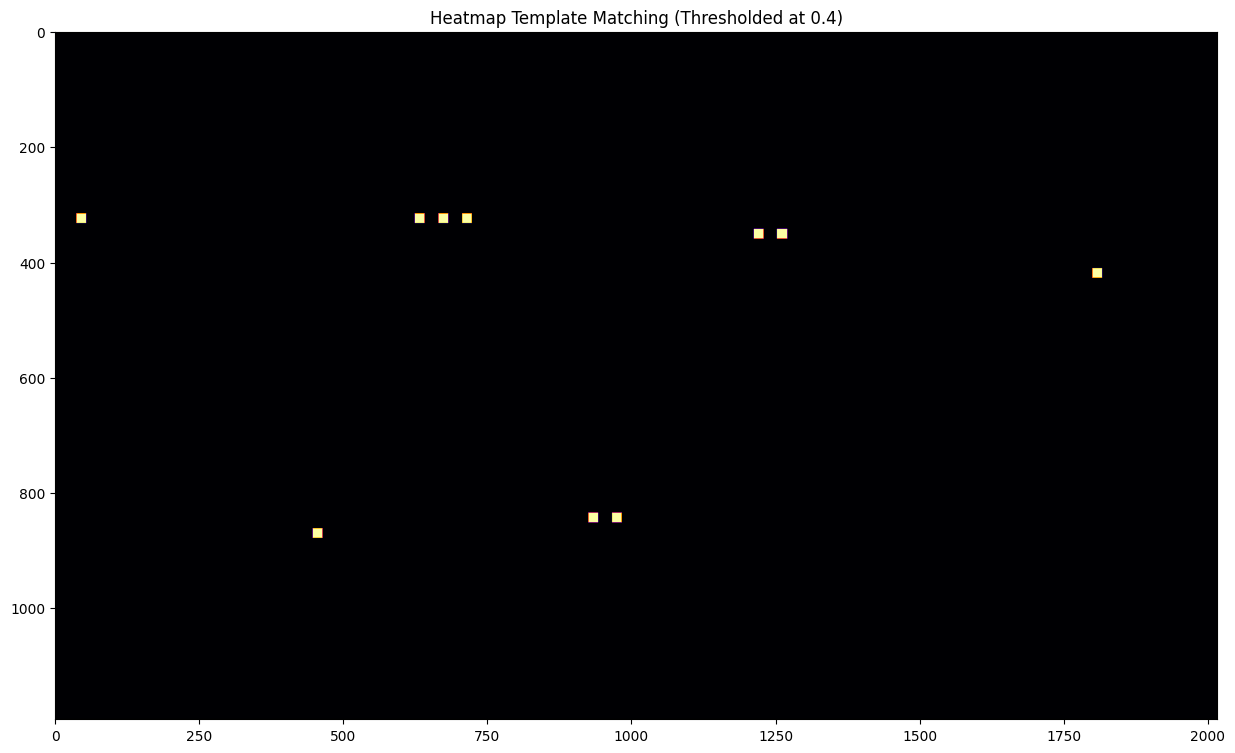

In [24]:
# Draw the thresholded results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(thresholded_res, cmap='inferno_r')
ax.set_title(f'Heatmap Template Matching (Thresholded at {threshold})')
plt.show()

### 2D on Target Image

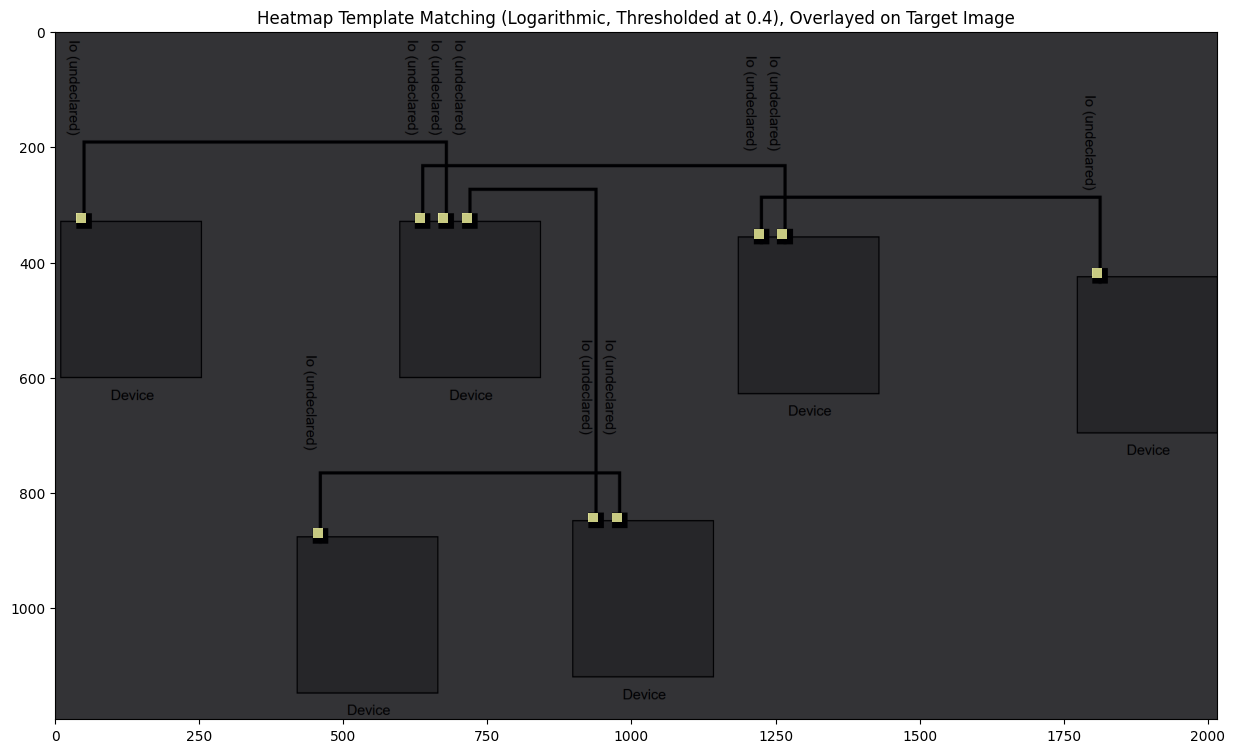

In [25]:
# Overlay the thresholded heatmap on the original image
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.imshow(thresholded_res, cmap='inferno_r', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Logarithmic, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

#### 2D big Xes on Target Image

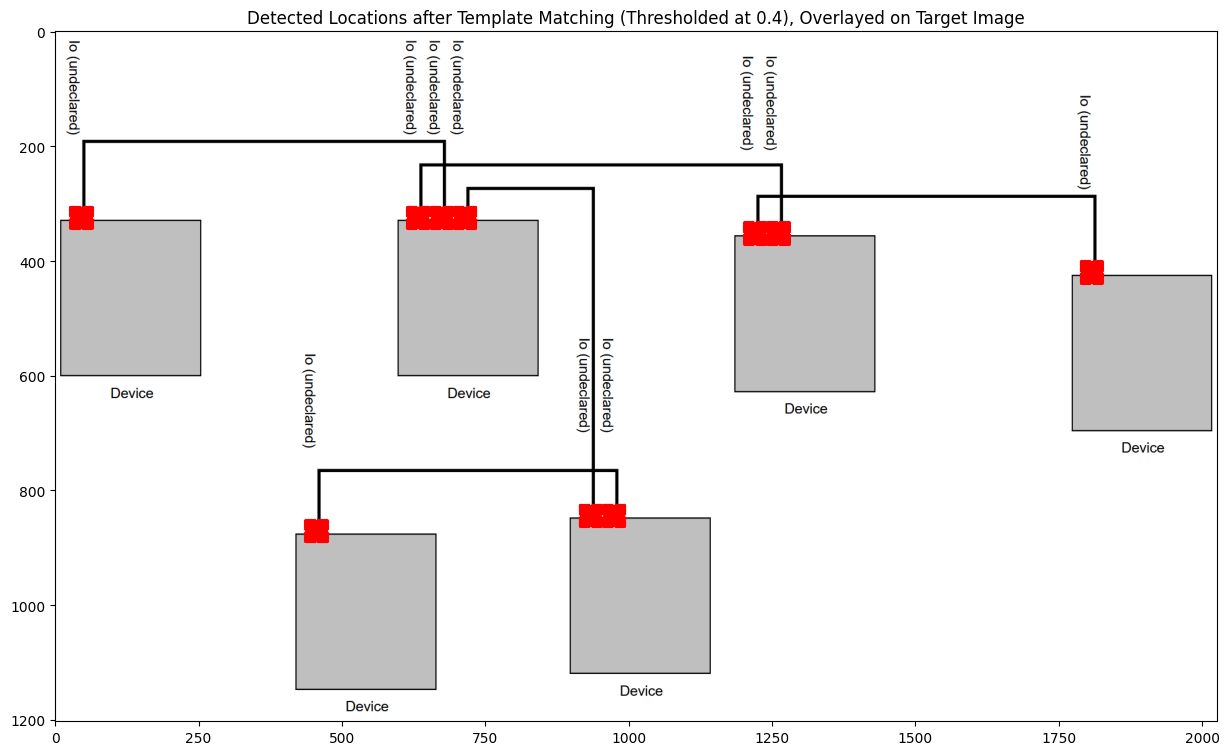

In [26]:
# draw the loc as points
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.scatter(loc[1], loc[0], c='r', s=100, marker='x')
plt.title(f'Detected Locations after Template Matching (Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

### 3D with Plotly

In [27]:
activate_plotly = False
if activate_plotly:
    fig = go.Figure(data=[go.Surface(z=-np.log(thresholded_res+1))])
    fig.update_layout(title='Heatmap Template Matching', height=1200, scene=dict(yaxis=dict(autorange="reversed")))
    fig.show()


### 2D with Plotly

In [28]:
# again with plotly, but 2D
activate_plotly = False
if activate_plotly:
    fig = go.Figure(
        data=go.Heatmap(
            z=thresholded_res, 
            colorscale='inferno_r')
            )
    fig.update_layout(title='Heatmap Template Matching', 
                      height=1200, 
                      yaxis=dict(
                          autorange='reversed'
                          )
                     )
    fig.show()

### No Foreground Filter
but small conversion of result

In [29]:
"""Case ports: no need to check for foreground. Just return the all points. Background: tranpsarent, so no need to check for foreground."""
loc_converted = []
for pt in zip(*loc[::-1]):
    loc_converted.append(pt)

print(loc_converted)

[(np.int64(37), np.int64(316)), (np.int64(38), np.int64(316)), (np.int64(39), np.int64(316)), (np.int64(40), np.int64(316)), (np.int64(41), np.int64(316)), (np.int64(42), np.int64(316)), (np.int64(43), np.int64(316)), (np.int64(44), np.int64(316)), (np.int64(45), np.int64(316)), (np.int64(46), np.int64(316)), (np.int64(47), np.int64(316)), (np.int64(48), np.int64(316)), (np.int64(49), np.int64(316)), (np.int64(50), np.int64(316)), (np.int64(51), np.int64(316)), (np.int64(52), np.int64(316)), (np.int64(53), np.int64(316)), (np.int64(624), np.int64(316)), (np.int64(625), np.int64(316)), (np.int64(626), np.int64(316)), (np.int64(627), np.int64(316)), (np.int64(628), np.int64(316)), (np.int64(629), np.int64(316)), (np.int64(630), np.int64(316)), (np.int64(631), np.int64(316)), (np.int64(632), np.int64(316)), (np.int64(633), np.int64(316)), (np.int64(634), np.int64(316)), (np.int64(635), np.int64(316)), (np.int64(636), np.int64(316)), (np.int64(637), np.int64(316)), (np.int64(638), np.int64

### Fill bounding boxes

In [30]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_converted:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

#### Plot filled bounding boxes

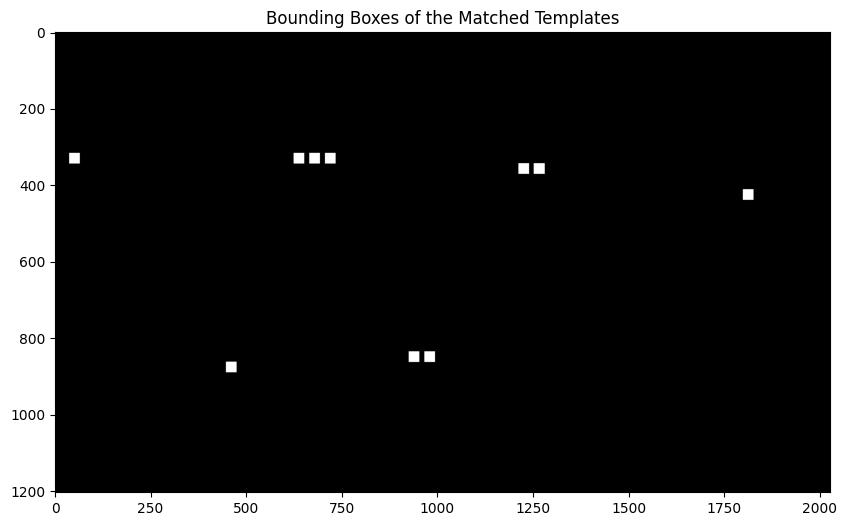

In [31]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
plt.title('Bounding Boxes of the Matched Templates')
plt.show()

### Find Contours in the super boxes

In [32]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours or compute their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (125, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(447, 862, 28, 28), (966, 835, 28, 28), (925, 835, 28, 28), (1799, 411, 28, 28), (1252, 343, 29, 28), (1212, 343, 28, 28), (706, 316, 28, 28), (665, 316, 28, 28), (624, 316, 28, 28), (37, 316, 28, 28)]


#### Visualize the super boxes

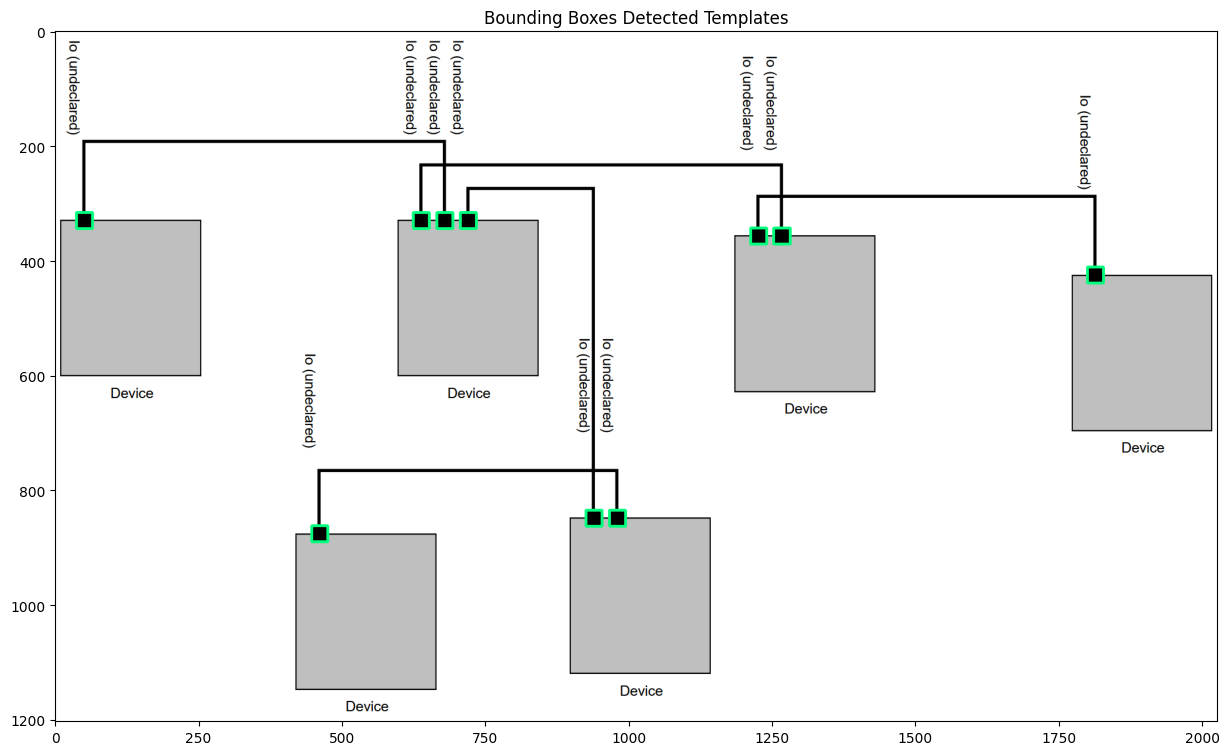

In [33]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_boundings_grouped, cv2.COLOR_BGR2RGB))
ax.set_title("Bounding Boxes Detected Templates")
plt.show()